In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

Reading data

In [ ]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X = pd.DataFrame( data = mnist.data, columns = mnist.feature_names )
Y = pd.DataFrame(data = mnist.target, columns = ['target'])

In [ ]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X.tail()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
Y.head()

,target
0,5
1,0
2,4
3,1
4,9


Encoding

In [ ]:
Y['target'] = Y['target'].astype(int)
Y['target'] = np.where(Y['target'] == 5, 1, 0)

In [ ]:
Y.head()

,target
0,1
1,0
2,0
3,0
4,0


In [ ]:
Y.target.value_counts()

target
0    63687
1     6313
Name: count, dtype: int64

Undersampling

In [ ]:
underSampler = RandomUnderSampler(sampling_strategy='auto')
X_underSampled, Y_underSampled = underSampler.fit_resample(X, Y)
Y_underSampled.value_counts()

target
0         6313
1         6313
Name: count, dtype: int64

In [ ]:
X.isnull().sum()

pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 784, dtype: int64

In [ ]:
X.duplicated().sum()

0

Histogram

In [ ]:
def histogram(x):
  n = len(x.columns)

  col = 3
  row = n//col + 1

  plt.figure(figsize = (15, 25))
  for i in range(n):
    plt.subplot(row, col, i+1)
    sns.histplot( x = x[x.columns[i]], bins=30, color='blue', edgecolor='black', kde=True)
    plt.xlabel(x.columns[i])
    plt.ylabel('Frequency')
  plt.show()

Correlation matrix

In [ ]:
def correlation_matrix(x):
  correlation_matrix = x.corr()

  plt.figure(figsize=(15, 10))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
  plt.show()

Function to calculate best threshold

In [ ]:
def best_threshold(y_true, y_scores):
  roc_auc = roc_auc_score(y_true, y_scores)
  precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
  f1_scores = 2 * recall * precision / (recall + precision)
  threshold = thresholds[np.argmax(f1_scores)]
  return threshold

Confusion Matrix

In [ ]:
def confusionMatrix(actual, prediction):
  conf_matrix = confusion_matrix(actual, prediction)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

Function to plot PR - Curve

In [ ]:
def plot_pr_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', label=f'PR curve (AP = {average_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

Function to plot ROC - Curve

In [ ]:
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

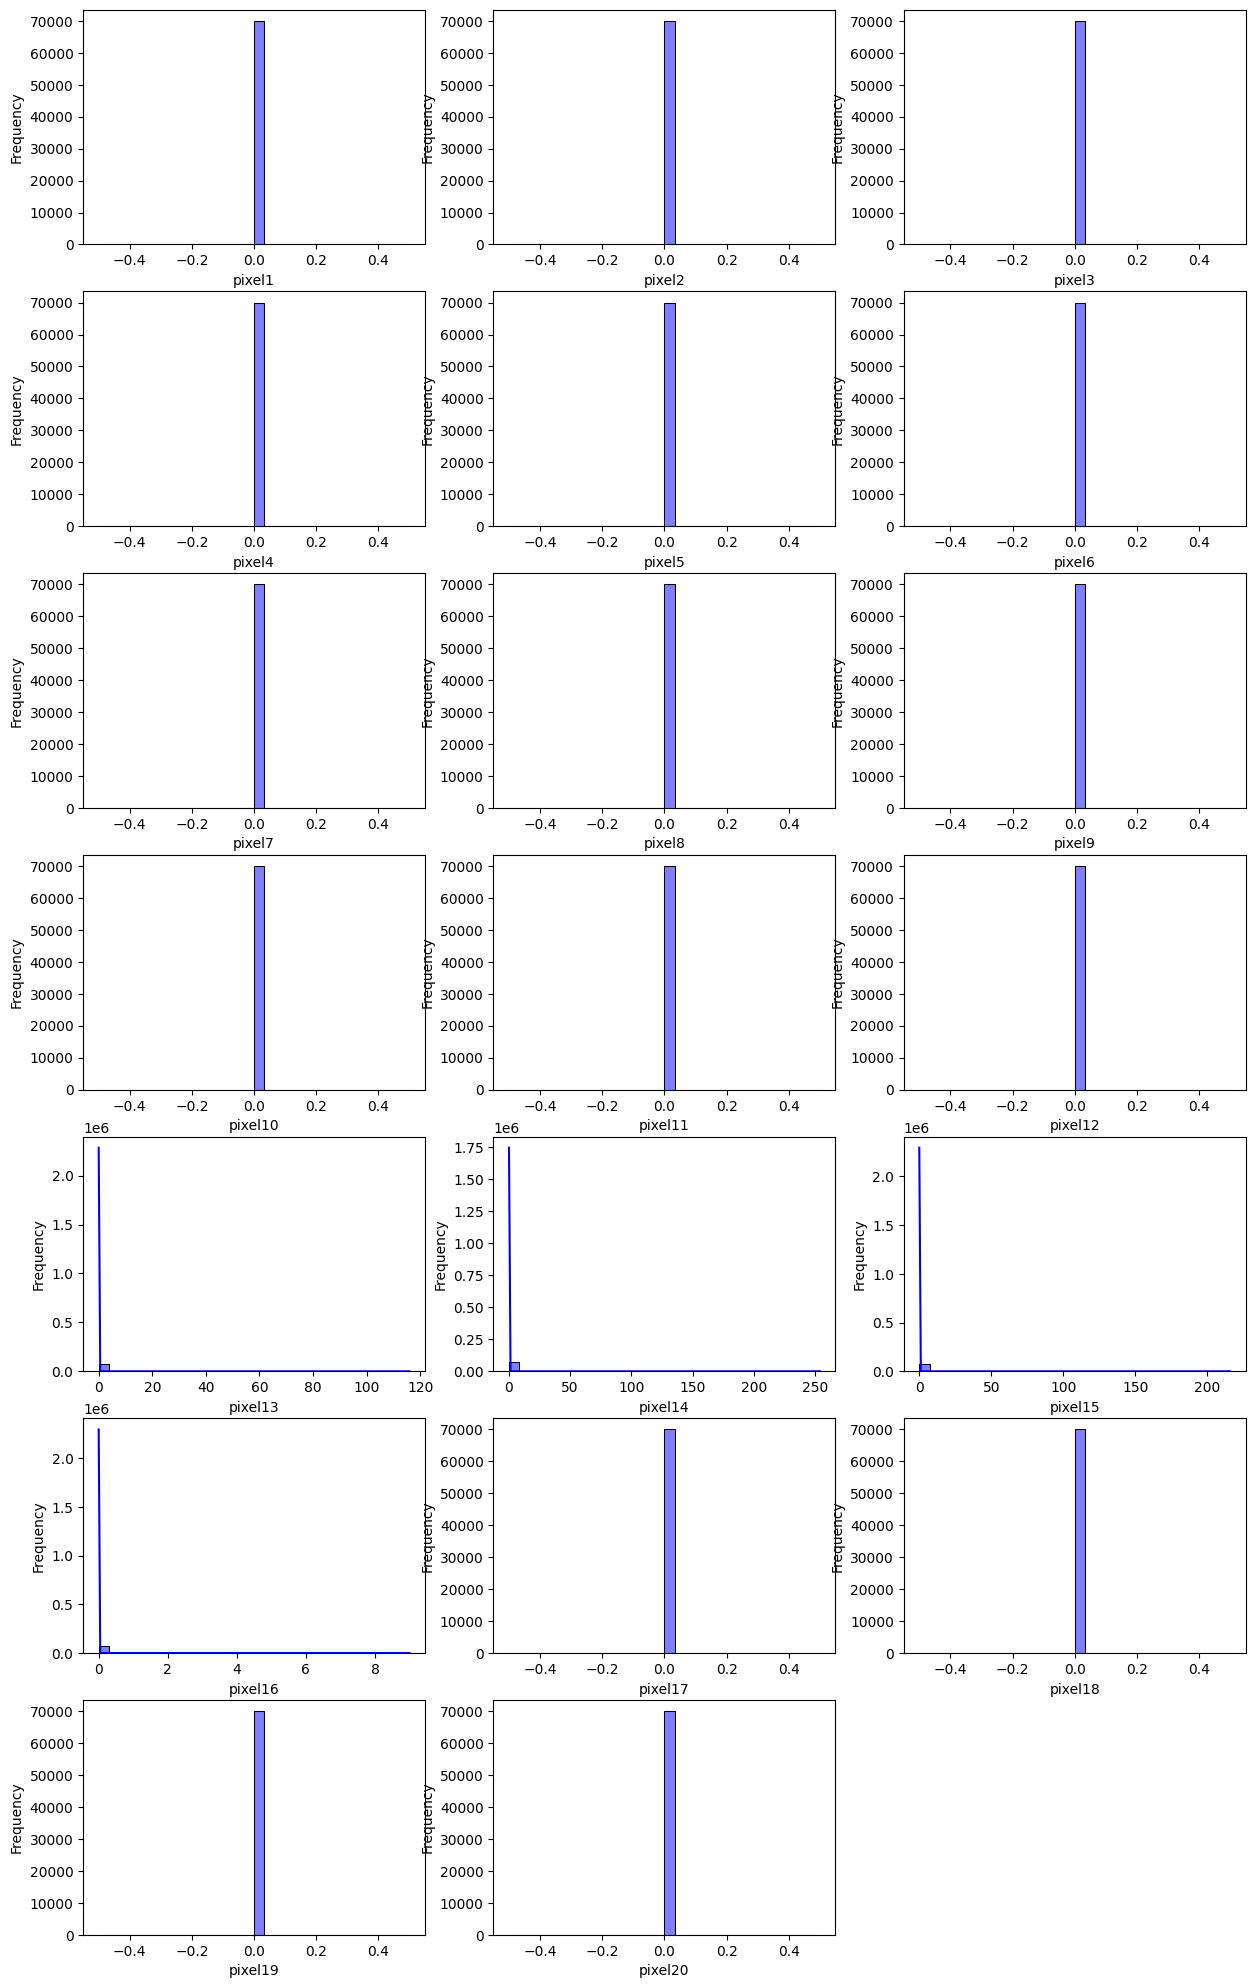

In [ ]:
histogram(X.iloc[:,:20])

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


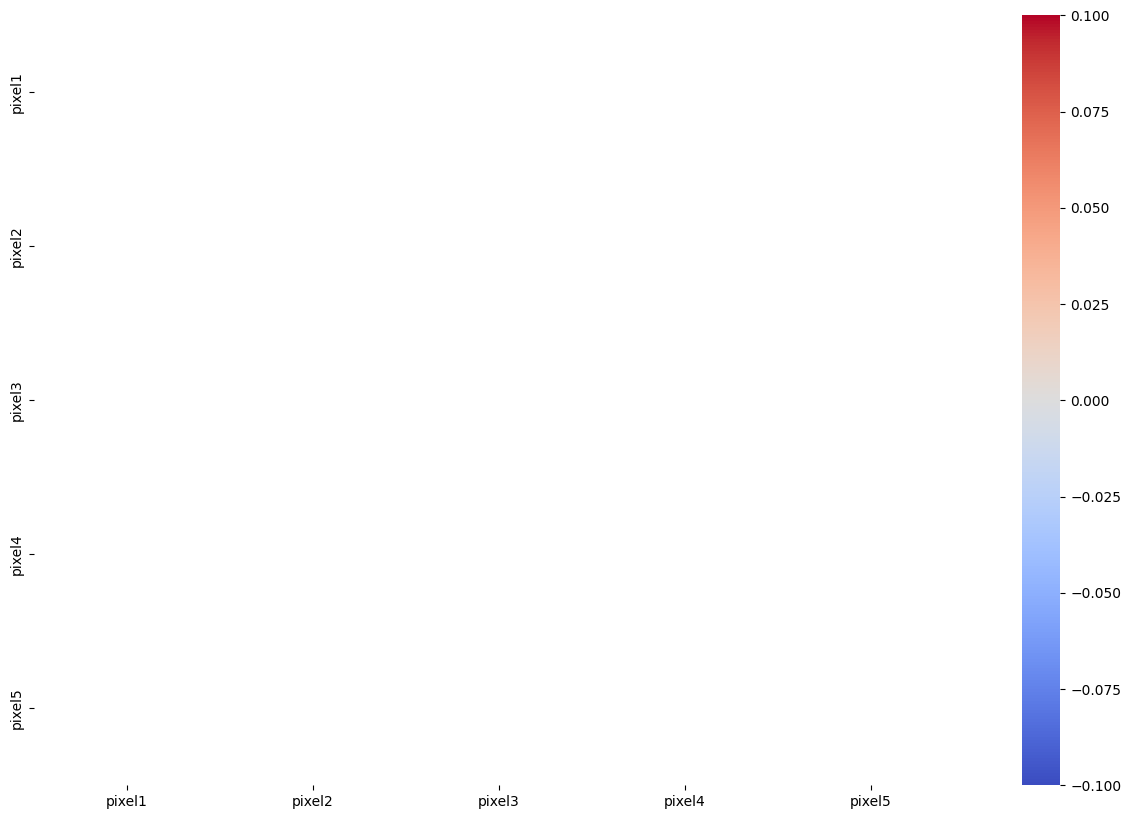

In [ ]:
correlation_matrix(X.iloc[:,:5])

Train Test Split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_underSampled, Y_underSampled, test_size = 0.2, stratify=Y_underSampled, random_state = 0)

MODEL TRAINING

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, Y_train.values.ravel())

y_train_prob = clf.predict_proba(X_train)[:, 1]
y_test_prob = clf.predict_proba(X_test)[:, 1]

threshold = best_threshold(Y_train, y_train_prob)

Y_train_pred = (y_train_prob >= threshold).astype(int)
print(f"Training Accuracy = {accuracy_score(Y_train, Y_train_pred)}")

Y_test_pred = (y_test_prob >= threshold).astype(int)
print(f"Testing Accuracy = {accuracy_score(Y_test, Y_test_pred)}")

Training Accuracy = 1.0
Testing Accuracy = 0.9663499604117182


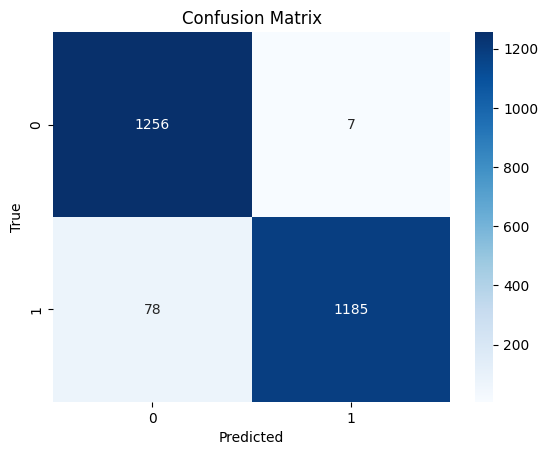

In [ ]:
confusionMatrix(Y_test, Y_test_pred)

In [ ]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1263
           1       0.99      0.94      0.97      1263

    accuracy                           0.97      2526
   macro avg       0.97      0.97      0.97      2526
weighted avg       0.97      0.97      0.97      2526



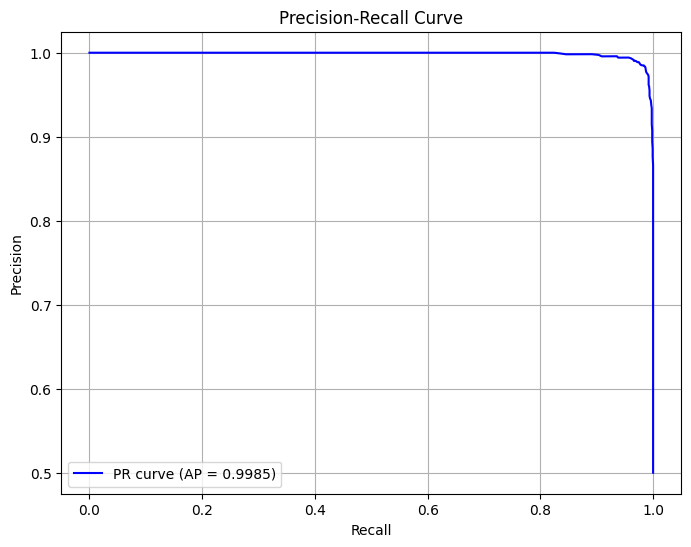

In [ ]:
plot_pr_curve(Y_test, y_test_prob)

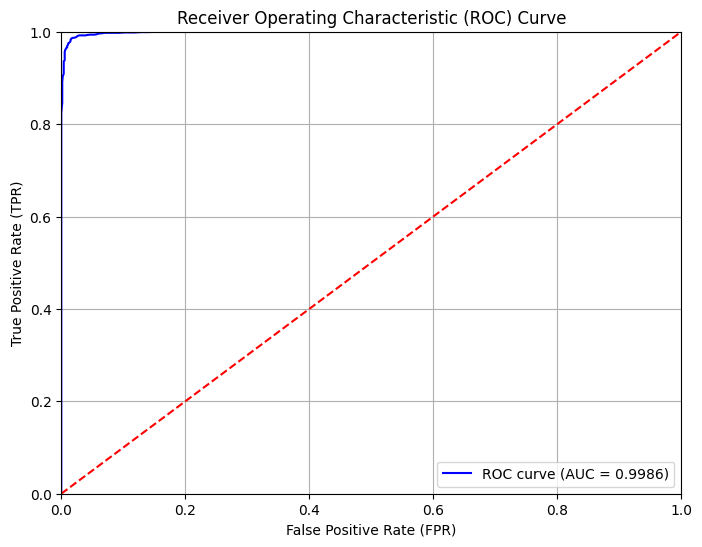

In [ ]:
plot_roc_curve(Y_test, y_test_prob)

In [ ]:
cat = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
cat.fit(X_train, Y_train.values.ravel())

y_train_prob = cat.predict_proba(X_train)[:, 1]
y_test_prob = cat.predict_proba(X_test)[:, 1]

threshold = best_threshold(Y_train, y_train_prob)

Y_train_pred = (y_train_prob >= threshold).astype(int)
print(f"Training Accuracy = {accuracy_score(Y_train, Y_train_pred)}")

Y_test_pred = (y_test_prob >= threshold).astype(int)
print(f"Testing Accuracy = {accuracy_score(Y_test, Y_test_pred)}")

Training Accuracy = 0.9993069306930693
Testing Accuracy = 0.9857482185273159


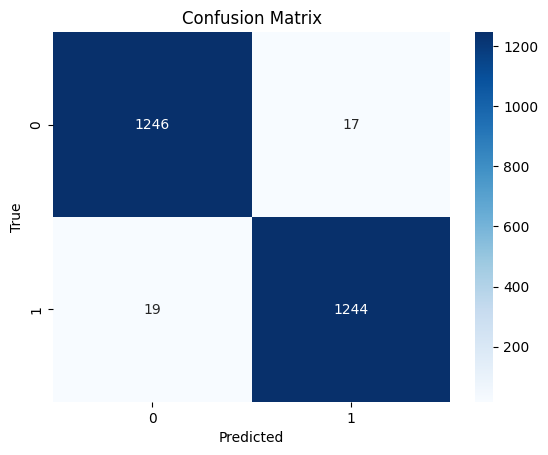

In [ ]:
confusionMatrix(Y_test, Y_test_pred)

In [ ]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1263
           1       0.99      0.98      0.99      1263

    accuracy                           0.99      2526
   macro avg       0.99      0.99      0.99      2526
weighted avg       0.99      0.99      0.99      2526



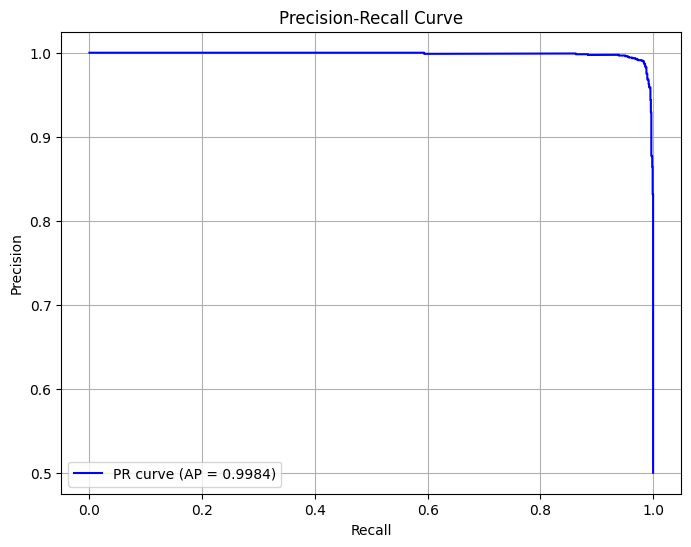

In [ ]:
plot_pr_curve(Y_test, y_test_prob)

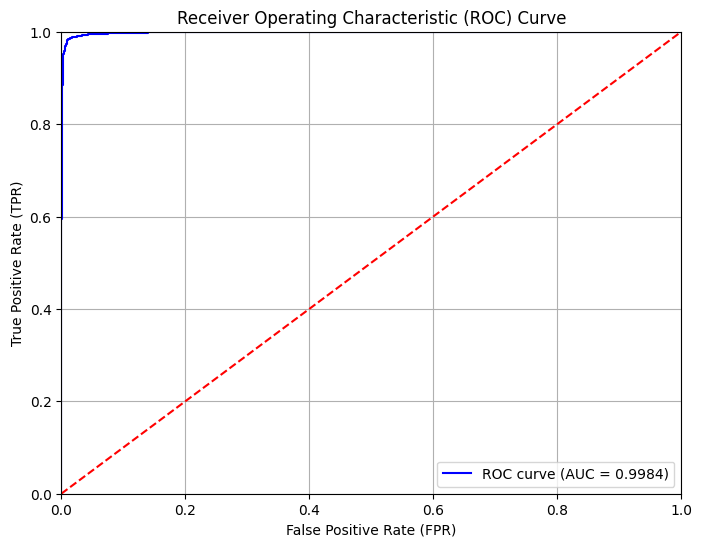

In [ ]:
plot_roc_curve(Y_test, y_test_prob)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=3000, learning_rate_init = 0.001, alpha = 2 , learning_rate = 'adaptive', hidden_layer_sizes = (100, 50, 50))
mlp.fit(X_train, Y_train.values.ravel())

Training_pred_mpl= mlp.predict(X_train)
print(f"Training Accuracy = {accuracy_score(Y_train, Training_pred_mpl)}")

y_test_prob = mlp.predict_proba(X_test)[:,1]
Testing_pred_mlp = mlp.predict(X_test)
print(f"Testing Accuracy = {accuracy_score(Y_test, Testing_pred_mlp)}")

Training Accuracy = 0.9977227722772277
Testing Accuracy = 0.9837688044338876


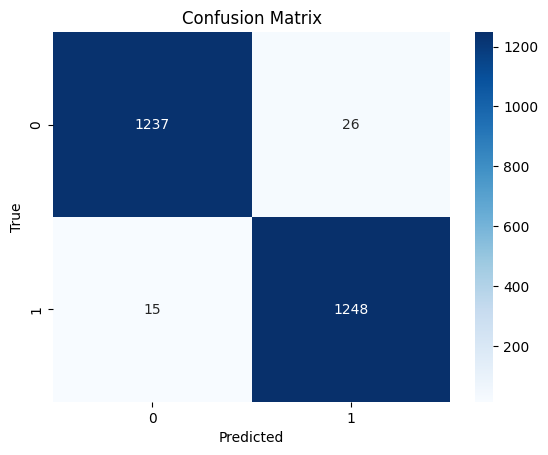

In [ ]:
confusionMatrix(Y_test, Testing_pred_mlp)

In [ ]:
print(classification_report(Y_test, Testing_pred_mlp))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1263
           1       0.98      0.99      0.98      1263

    accuracy                           0.98      2526
   macro avg       0.98      0.98      0.98      2526
weighted avg       0.98      0.98      0.98      2526



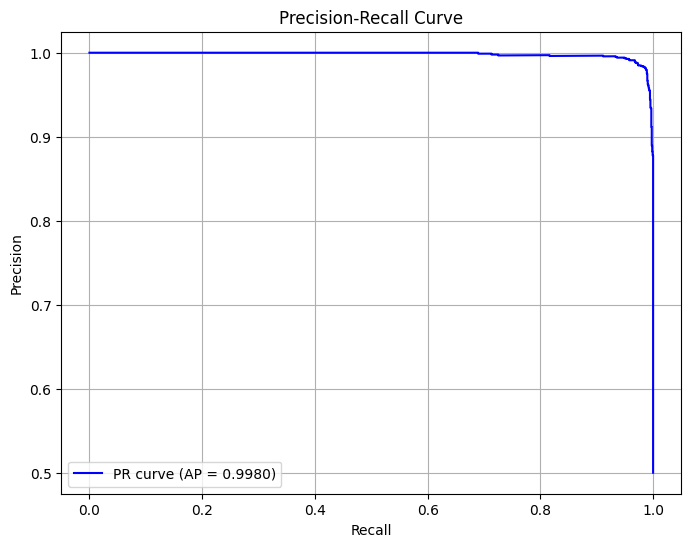

In [ ]:
plot_pr_curve(Y_test, y_test_prob)

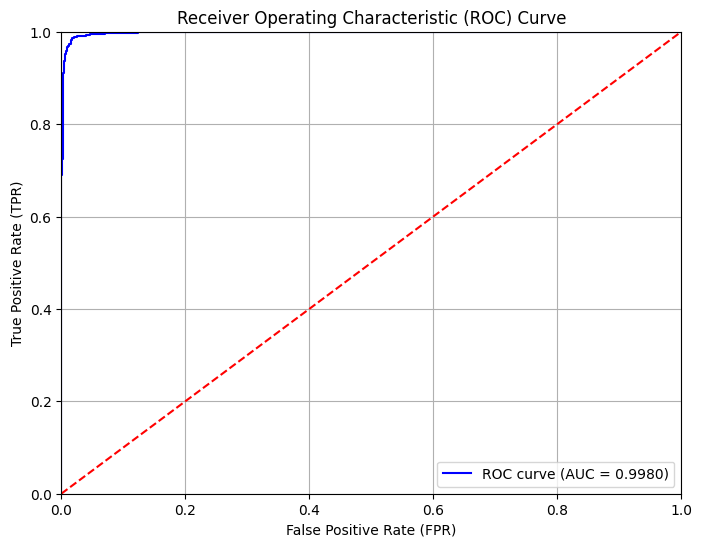

In [ ]:
plot_roc_curve(Y_test, y_test_prob)